# SYSID - Atividade 08

Aluno: Pedro Henrique Cardoso Paulo<br>

Professor: Helon

## Objetivo

TBD

## Passo 0 - Importando bibliotecas

In [59]:
# Pacotes padrao
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import datetime

#sysidentpy
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.general_estimators.narx import NARX
from sysidentpy.neural_network import NARXNN
from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation
from sysidentpy.utils.narmax_tools import regressor_code

#Pipeline
from sklearn.pipeline import Pipeline

#Tratamento
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Modelos
from sklearn.model_selection import RandomizedSearchCV

# Scores
from sklearn.metrics import r2_score

from architecture import *

#Definindo random_state
rs = 85

## Passo 0 - Importando os dados

### 0.1 - Lendo dados

In [60]:
binary = os.path.join(os.getcwd(), 'data', 'volve_compiled.pkl')
print(binary)

with open(binary, 'rb') as bin_file:
    data = pickle.load(bin_file)

/mnt/d/OneDrive/Mestrado/Semestre 02/SYSID/SYSID_Trabalho/Volve-Dataset/data/volve_compiled.pkl


In [61]:
for wellp in data['OP'].keys():
    print(wellp)

15/9-F-1 C
15/9-F-11
15/9-F-12
15/9-F-14
15/9-F-15 D
15/9-F-5


### 0.2 - Visualizando dados

10-31 14:07:19 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
10-31 14:07:19 - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


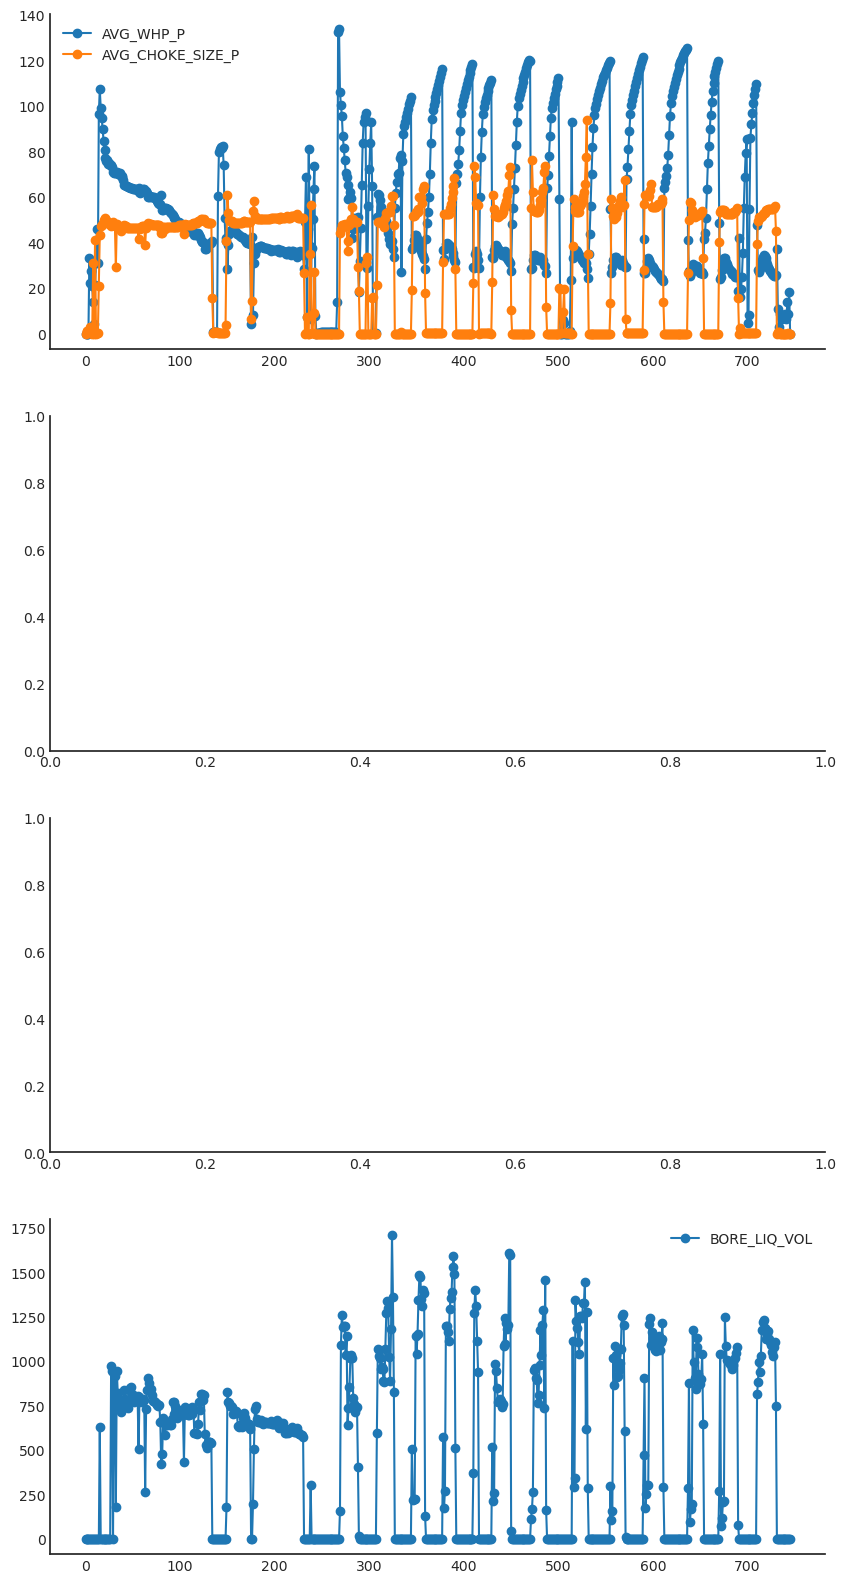

In [62]:
case = "15/9-F-1 C"
#case = "15/9-F-11"

data_case = data['OP'][case]

filt_vars_IN_Q =  [
        #'BORE_OIL_VOL',
        #'BORE_GAS_VOL',
        #'BORE_WAT_VOL',
        #'BORE_OIL_CUM',
        #'BORE_LIQ_CUM',
        #'BORE_GAS_CUM',
        #'BORE_WAT_CUM',
]

filt_vars_IN_QINJ = [
        'BORE_WI_VOL',
        'BORE_WI_CUM',
]

filt_vars_IN_P = [
        #'AVG_DOWNHOLE_PRESSURE',
        'AVG_WHP_P',
        #'AVG_DP_TUBING',
        #'AVG_ANNULUS_PRESS',
        'AVG_CHOKE_SIZE_P',
        #'DP_CHOKE_SIZE',
]

filt_vars_IN_T = [
        #'AVG_WHT_P',
        #'AVG_DOWNHOLE_TEMPERATURE',
]

filt_vars_OUT = [
        #'BORE_OIL_VOL',
        'BORE_LIQ_VOL',
        #'AVG_DOWNHOLE_PRESSURE',
]

time = data_case['N']
fig, ax = plt.subplots(4,1, figsize=(10, 20))
for var in filt_vars_IN_P:
    ax[0].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_Q:
    ax[1].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_IN_T:
    ax[2].plot(time, data_case[var], '-o', label=var)
for var in filt_vars_OUT:
    ax[3].plot(time, data_case[var], '-o', label=var)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()

In [63]:
data_case = data_case.loc[28:,:]
data_case = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T + filt_vars_OUT].dropna()
X1 = data_case[filt_vars_IN_Q + filt_vars_IN_P + filt_vars_IN_T].values
y =  data_case[filt_vars_OUT].values

## Passo 1 - Separando os dados em treino e teste

### 1.1 - Definindo a parcela de treino e de teste

In [64]:
p_train = 0.5 #50% treino

### 1.2 - Separando os conjuntos

In [65]:
n_train = int(X1.shape[0]*p_train)
X1_tr = X1[:n_train,:]
y_tr = y[:n_train,:]
X1_te = X1[n_train:,:]
y_te = y[n_train:,:]

In [66]:
print(
    X1_tr.shape,
    X1_te.shape
)

(359, 2) (359, 2)


### 1.3 - Normalizando as variáveis

In [67]:
scaler_X = MinMaxScaler().fit(X1_tr)
scaler_y = MinMaxScaler().fit(y_tr)

X1_tr = scaler_X.transform(X1_tr)
X1_te = scaler_X.transform(X1_te)

y_tr  = scaler_y.transform(y_tr)
y_te  = scaler_y.transform(y_te) 

## Passo 2 - Iniciando a construção do modelo ARMAX/NARMAX

Para essa atividade, vamos usar a biblioteca sysidentpy. Essa biblioteca guarda grandes similaridades com bibliotecas da área de machine learning, como `scikit-learn`, `tensorflow` e `pytorch`.
Como na <a href="../Atividade06/Atividade06.ipynb">Atividade 06</a> o modelo que usamos de base mostrou-se divergente para a simulação livre, vamos aqui tentar propor um modelo ligeiramente diferente de base, com `na = nb = 6`. Além disso, vamos adicionar 4 termos não-lineares por padrão nos coeficientes do ajuste por meio do parâmetro n_terms.

### 2.1 - Selecionando a arquitetura (NARMAX)

Para esse caso, como o númeroo de termos tende a crescer muito, vamos deixar o sysidentpy selecionar a ordem de nossos modelos

In [68]:
basis_function = Fourier(degree=2)
na = 6
nb = [6] * X1.shape[1]
ne = 1
n_terms = 6
model_NARMAX = NARXNN(
    ylag=na,
    xlag=nb,
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func='mse_loss',
    optimizer='Adam',
    epochs=2000,
    verbose=False,
    device=device,
    optim_params={
        'betas': (0.9, 0.999),
        'eps': 1e-05
        }
)

regressors = regressor_code(X=X1_tr,
    xlag=nb,
    ylag=na,
    model_type="NARMAX",
    model_representation="neural_network",
    basis_function=basis_function
)
print(regressors.shape)
model_NARMAX.net = NARX(regressors.shape[0])
model_NARMAX.net.to(torch.device(device))

(567, 2)


NARX(
  (lin): Linear(in_features=567, out_features=80, bias=True)
  (lin2): Linear(in_features=80, out_features=80, bias=True)
  (lin3): Linear(in_features=80, out_features=1, bias=True)
  (relu): ReLU6()
)

### 2.3 - Selecionando arquitetura (ARMAX)

In [69]:
basis_function = Polynomial(degree=1)
n = 2
na = n
nb = [n] * X1.shape[1]
ne = 1
n_terms = 6
model_ARMAX = FROLS(
    order_selection=True,
    ylag=na, xlag=nb,elag=ne,
    basis_function=basis_function,
    n_info_values=100,
    #n_terms=n_terms,
    model_type='NARMAX',
    extended_least_squares=True,
)

## Passo 3 - Realizando ajuste inicial

### 3.1 - Performando o ajuste

In [70]:
model_NARMAX.fit(X=X1_tr, y=y_tr)
model_ARMAX.fit(X=X1_tr, y=y_tr)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x132 and 567x80)

### 3.2 - Visualizando os resultados (NARMAX)

### 3.3 - Visualizando os resultados (ARMAX)

In [ ]:
r = pd.DataFrame(
    results(
        model_ARMAX.final_model, model_ARMAX.theta, model_ARMAX.err,
        model_ARMAX.n_terms, err_precision=8, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),8.7009E-01,9.17157192E-01
1,1,2.2645E-02,3.18369303E-03


### 3.4 - Comentários

Nota-se ao olharmos os valores do ajuste que os coeficientes lineares ficam sendo os de maior peso em ambos os casos. Além disso, a ordem dos coeficientes lineares em ambos os ajustes é a mesma, de modo que é esperado que os ajustes fiquem bem próximos, com os coeficientes lineares sendo os dominantes e pouco ganho n aplicação do NARMAX.

## Passo 4 - Comparando os resultados

### 4.1 - Calculando predição OSA

In [ ]:
y_tr_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

y_tr_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=1)
y_te_pr_OSA_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=1)

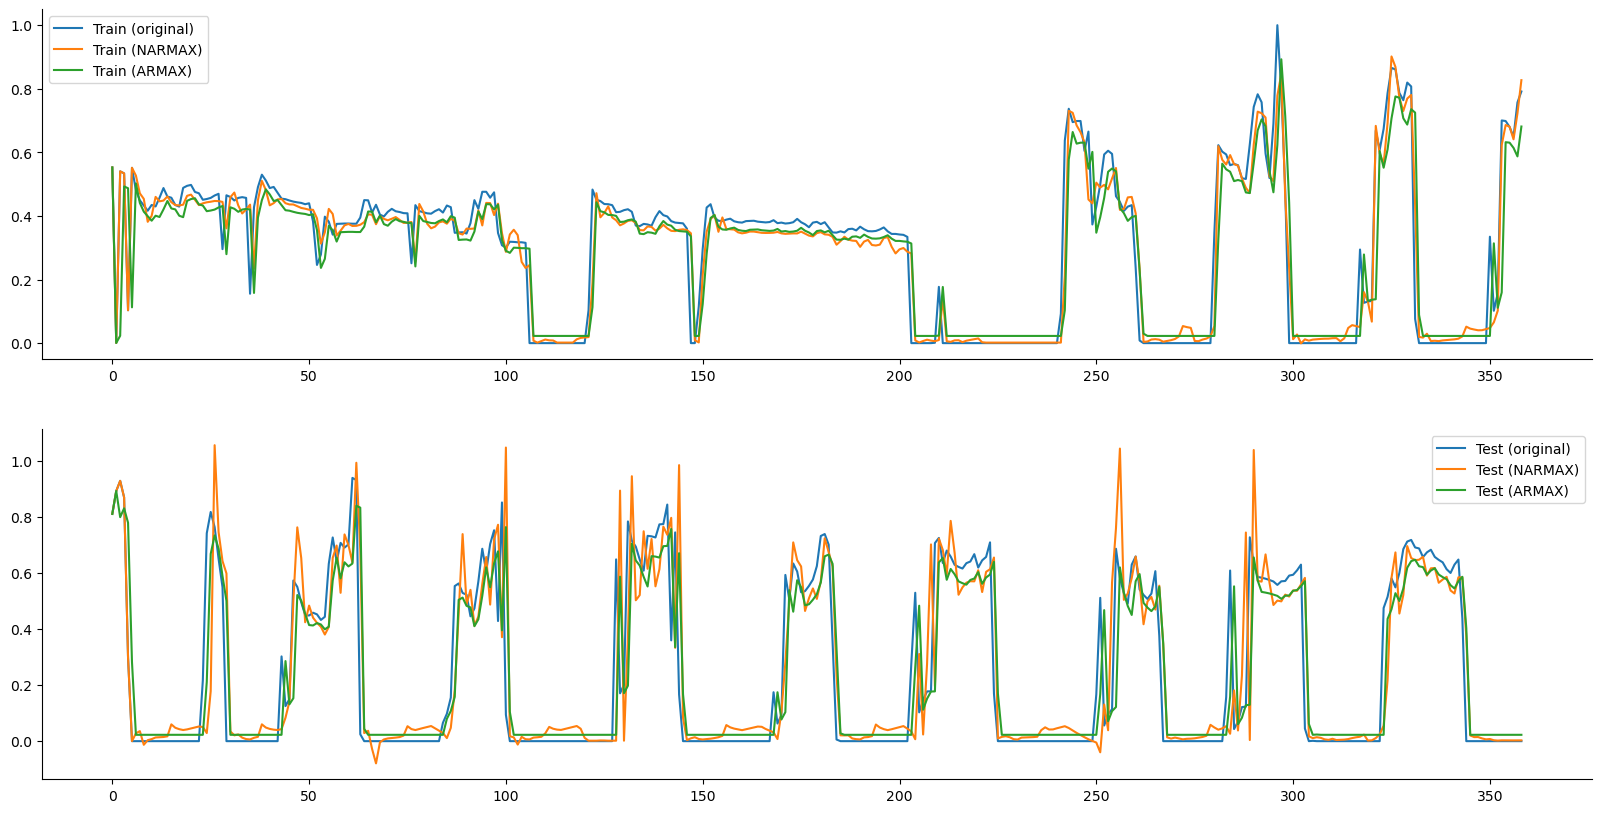

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_OSA_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_OSA_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_OSA_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_OSA_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [ ]:
print('ARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_ARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for OSA prediction (train) :', r2_score(y_tr, y_tr_pr_OSA_NARMAX))
print('R2 score for OSA prediction (test)  :', r2_score(y_te, y_te_pr_OSA_NARMAX))

ARMAX Results:
R2 score for OSA prediction (train) : 0.7811609474564869
R2 score for OSA prediction (test)  : 0.737239841596578

NARMAX Results:
R2 score for OSA prediction (train) : 0.9063090788103403
R2 score for OSA prediction (test)  : 0.662057091412963


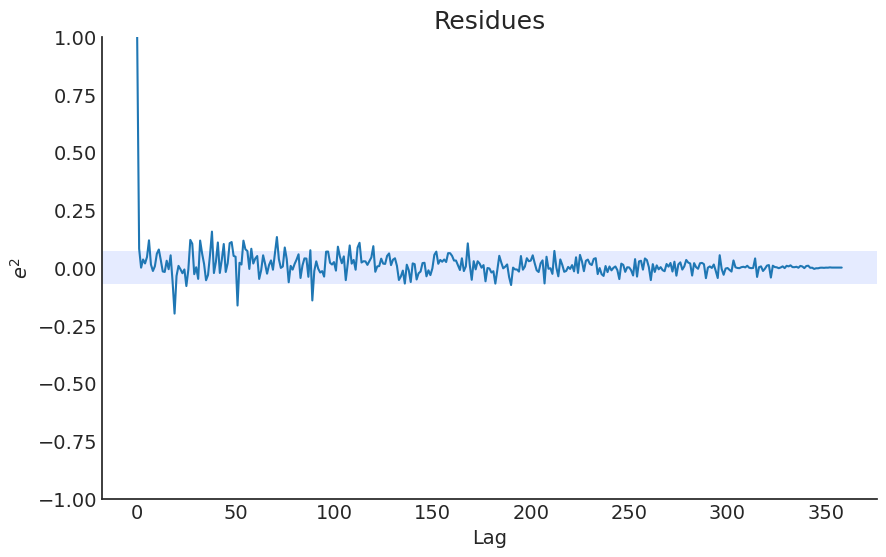

In [ ]:
ee = compute_residues_autocorrelation(y_tr, y_tr_pr_OSA_NARMAX)
plot_residues_correlation(data=ee, title="Residues", ylabel="$e^2$")

### 4.3 - Calculando predição FS

In [ ]:
steps = None
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

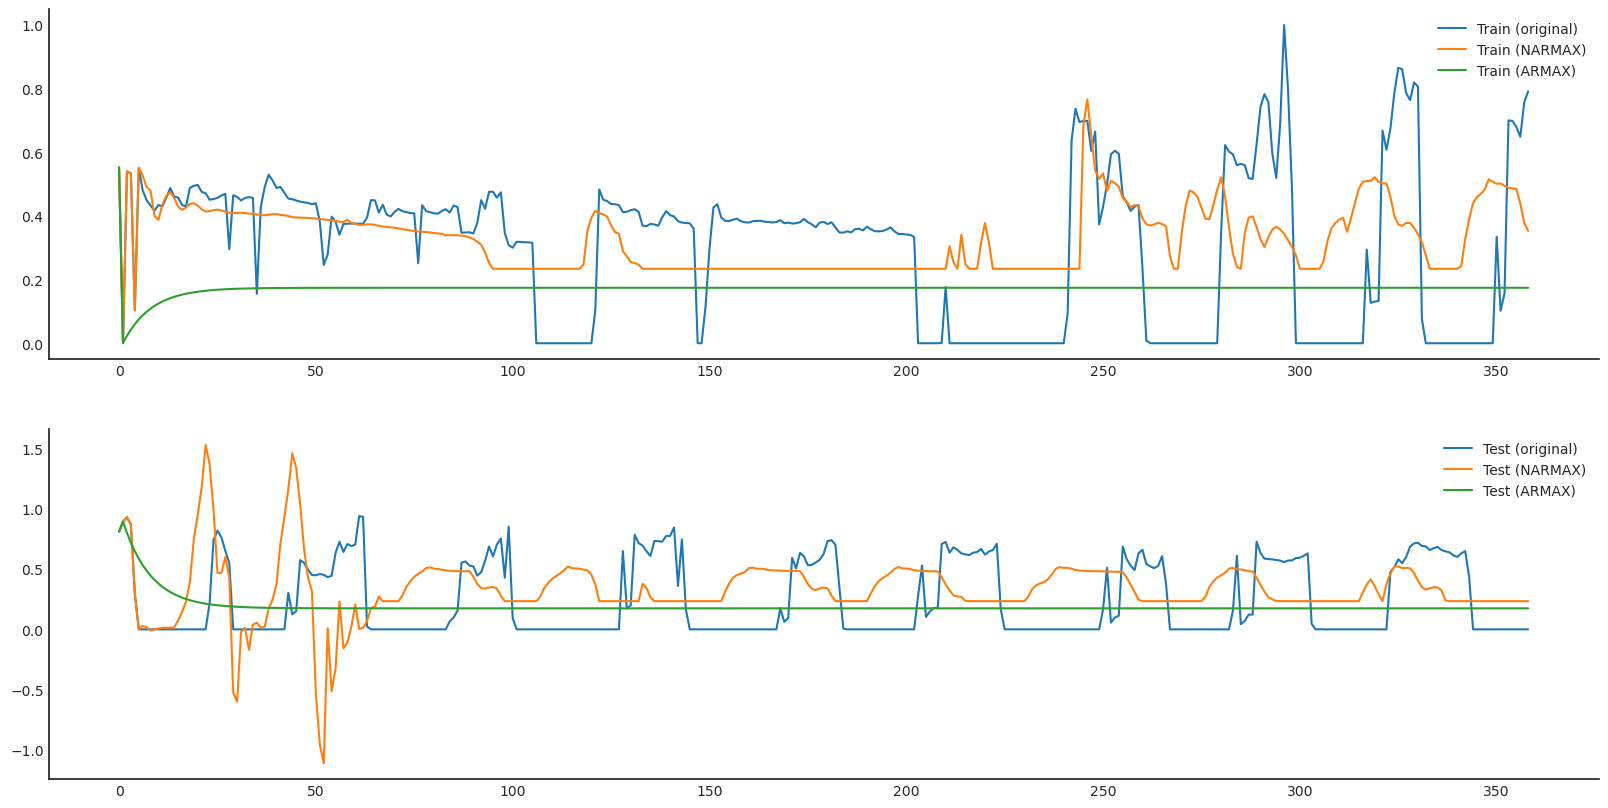

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [ ]:
print('ARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for FS prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for FS prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for FS prediction (train) : -0.3349033867355502
R2 score for FS prediction (test)  : -0.04199479468214751

NARMAX Results:
R2 score for FS prediction (train) : 0.06952327793497282
R2 score for FS prediction (test)  : -0.8299763755380982


### 4.4 - Calculando predição com ajuste de teste de produção

In [ ]:
steps = 60
y_tr_pr_FS_NARMAX = model_NARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_NARMAX = model_NARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)
y_tr_pr_FS_ARMAX = model_ARMAX.predict(X=X1_tr, y=y_tr,steps_ahead=steps)
y_te_pr_FS_ARMAX = model_ARMAX.predict(X=X1_te, y=y_te,steps_ahead=steps)

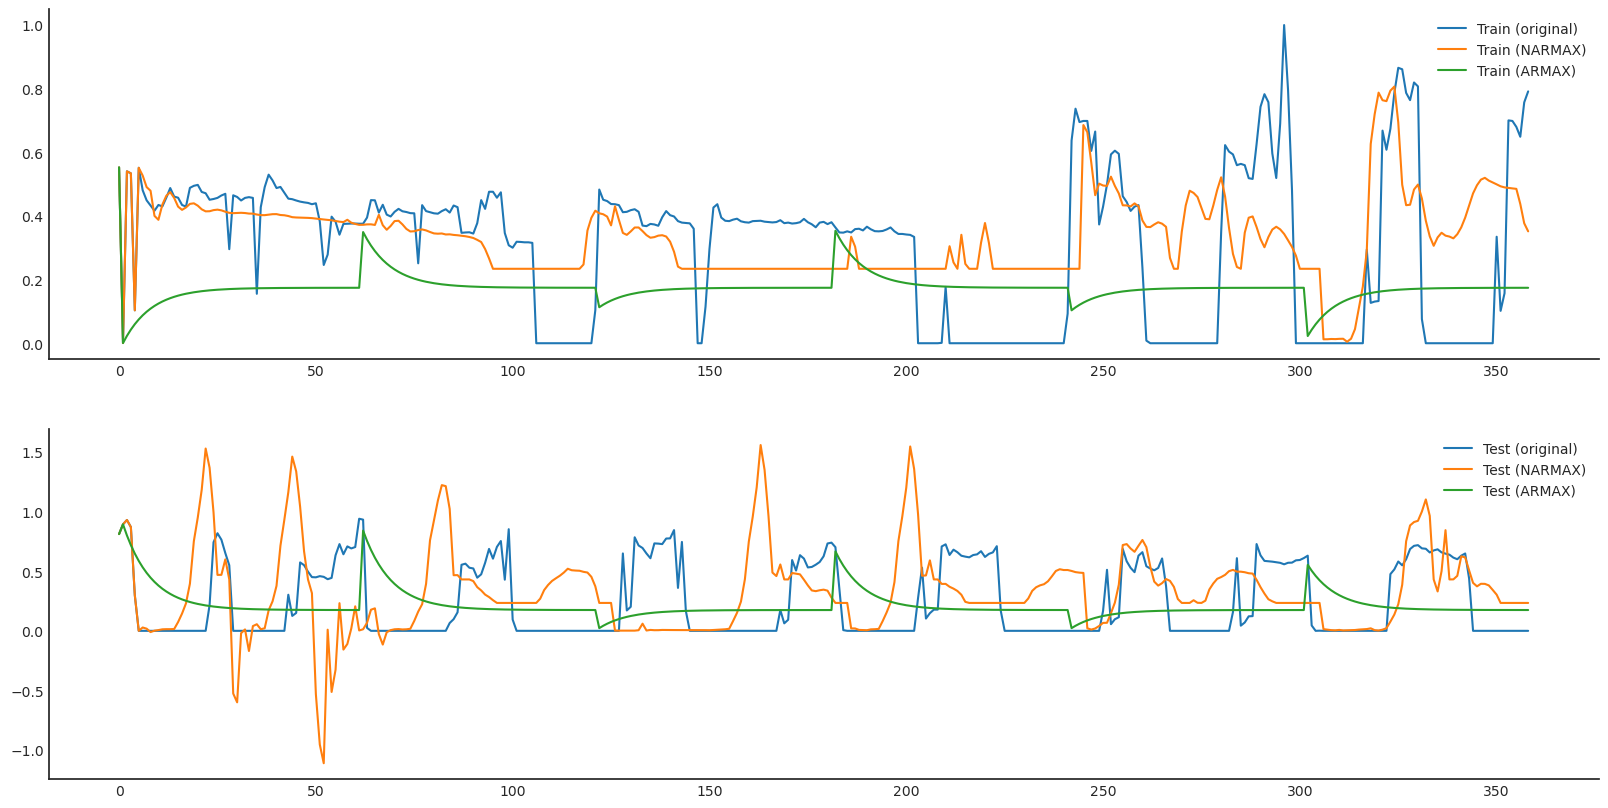

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(y_tr, label='Train (original)')
ax[0].plot(y_tr_pr_FS_NARMAX, label='Train (NARMAX)')
ax[0].plot(y_tr_pr_FS_ARMAX, label='Train (ARMAX)')
ax[1].plot(y_te, label='Test (original)')
ax[1].plot(y_te_pr_FS_NARMAX, label='Test (NARMAX)')
ax[1].plot(y_te_pr_FS_ARMAX, label='Test (ARMAX)')
ax[0].legend()
ax[1].legend()

In [ ]:
print('ARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_ARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_ARMAX))
print()
print('NARMAX Results:')
print('R2 score for n-steps prediction (train) :', r2_score(y_tr, y_tr_pr_FS_NARMAX))
print('R2 score for n-steps prediction (test)  :', r2_score(y_te, y_te_pr_FS_NARMAX))

ARMAX Results:
R2 score for n-steps prediction (train) : -0.3192619004012647
R2 score for n-steps prediction (test)  : -0.17531496586465223

NARMAX Results:
R2 score for n-steps prediction (train) : -2.1316170458243655
R2 score for n-steps prediction (test)  : -0.8779516435845467


## Passo 5 - Conclusões

FS tá ruim, mas OSA mostra que tem jogo